# Dog Breed Identification

This kaggle competition is to identify 120 breeds of dogs with limited number training images per class.

https://www.kaggle.com/c/dog-breed-identification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.conv_learner import *
from fastai.plots import *
from fastai.transforms import *
from fastai.model import *

## 1. Initial exploration

### 1.1 Data directory

In [3]:
PATH = '../data/dogbreed/'
os.listdir(PATH)

['train.zip',
 'test',
 'labels.csv.zip',
 'labels.csv',
 'models',
 'train',
 'tmp',
 'test.zip']

### 1.2 Preview the label file

In [4]:
label_csv = f'{PATH}labels.csv'
df = pd.read_csv(label_csv)
print(df.shape)
df.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


From the data frame above, we know we totally have 10222 images with name(id column) and label(breed column).

### 1.3 Show the distribution of dog breeds

In [13]:
breed_distri = df.pivot_table(index='breed',aggfunc=len).sort_values('id',ascending = False);breed_distri

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015D01CE8EB8>]], dtype=object)

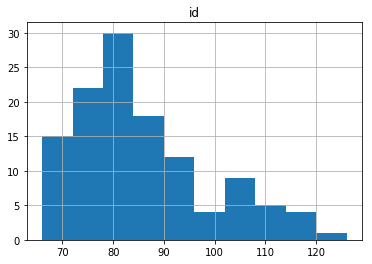

In [18]:
breed_distri.hist()

The above aggregate data frame and histgram show the distribution of the dog breeds, e.g. the scottish_deerhound has the most images which is 126, and the eskimo_dog has the least images which is 66, most breeds has 80 images.

### 1.4 View image

In [5]:
samples = os.listdir(f'{PATH}/train')[:5]
samples

['d8275152fe9027835bec0c405d131a2b.jpg',
 '44b4684cac2f73ba81b6ed86e45244ad.jpg',
 'bc218eeb424cf93092b0a0b23035bbad.jpg',
 'eba058daca887257dc71bfd2a0267d29.jpg',
 '92d23591a857f9adb0024d587683a1cd.jpg']

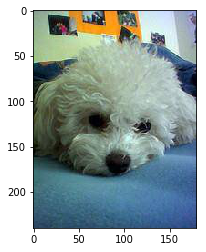

In [6]:
p = plt.imread(f'{PATH}/train/{samples[0]}')
plt.imshow(p)

### 1.5 View raw data

In [11]:
p.shape

(375, 500, 3)

By shape property, we can find the image above is 375\*500\*3 where 375 is the height of the image, and 500 is the width of the image, and 3 is the channel(Red, Green, Blue) of the image.

In [12]:
p[:4,:4]

array([[[109,  46,   0],
        [153,  91,  40],
        [180, 120,  68],
        [182, 127,  73]],

       [[153,  92,  47],
        [179, 121,  75],
        [167, 111,  64],
        [155, 102,  52]],

       [[152,  97,  56],
        [189, 136,  94],
        [164, 113,  70],
        [142,  95,  51]],

       [[114,  66,  30],
        [156, 110,  74],
        [145, 101,  64],
        [119,  77,  39]]], dtype=uint8)

### 1.6 View distributions of image size

In [21]:
imgs = os.listdir(f'{PATH}train/')

In [22]:
size_d = [PIL.Image.open(f'{PATH}train/{img}').size for img in imgs];size_d[:3]

[(500, 375), (500, 375), (500, 375)]

In [24]:
width,height = zip(*size_d)
width = np.array(width)
height = np.array(height)

#### 1.6.1 Distribution of width

(array([3798., 6259.,  108.,   18.,   11.,    4.,   19.,    2.,    1.,    2.]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

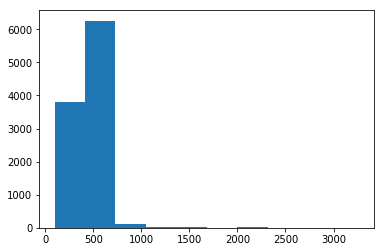

In [26]:
plt.hist(width)

From the histgram above, we find most of width are under 1000, so we use numpy to filter.

(array([ 178.,  762., 1671., 1486., 5705.,  155.,   98.,   72.,   15.,   12.]),
 array([ 97. , 186.3, 275.6, 364.9, 454.2, 543.5, 632.8, 722.1, 811.4, 900.7, 990. ]),
 <a list of 10 Patch objects>)

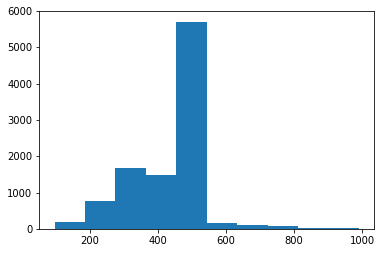

In [27]:
plt.hist(width[width<1000])

From the histogram above, we can find the most width of imgs are around 450

#### 1.6.2 Distribution of height

(array([3595., 6395.,  150.,   28.,   18.,   20.,   10.,    3.,    0.,    3.]),
 array([ 102.,  348.,  594.,  840., 1086., 1332., 1578., 1824., 2070., 2316., 2562.]),
 <a list of 10 Patch objects>)

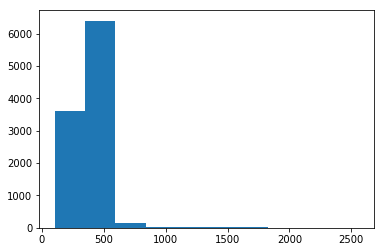

In [28]:
plt.hist(height)

(array([ 302.,  910., 2781., 3685., 2273.,  115.,   33.,   39.,    9.,   11.]),
 array([102. , 190.2, 278.4, 366.6, 454.8, 543. , 631.2, 719.4, 807.6, 895.8, 984. ]),
 <a list of 10 Patch objects>)

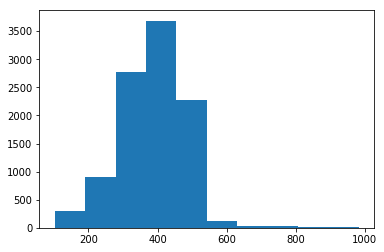

In [29]:
plt.hist(height[height<1000])

From the histogram above, we find the most height of images is around 400.

## 2. Model initialization

### 2.1 Get validation set

In [7]:
val_idxs = get_cv_idxs(df.shape[0])
val_idxs,val_idxs.shape

(array([2882, 4514, 7717, ..., 8922, 6774,   37]), (2044,))

### 2.2 Initial Architecture and data

In [8]:
arch = resnet34
sz = 224
bs = 64
def get_data(sz,bs):
    tfms = tfms_from_model(arch,sz=sz,aug_tfms=transforms_side_on,max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH,'train',label_csv,tfms = tfms, val_idxs=val_idxs,suffix='.jpg',test_name = 'test',num_workers=2,
                                       bs = bs)
    return data
data = get_data(sz,bs)
data.val_y,data.val_y.shape,data.classes[:5]

(array([ 19,  15,   7, ..., 109,   3,  28]),
 (2044,),
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

In [26]:
learn = ConvLearner.pretrained(arch,data)

In [29]:
%time learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 95%|█████████▌| 122/128 [00:50<00:02,  2.42it/s, loss=22]  CPU times: user 1min 12s, sys: 8.58 s, total: 1min 21s
Wall time: 50.8 s


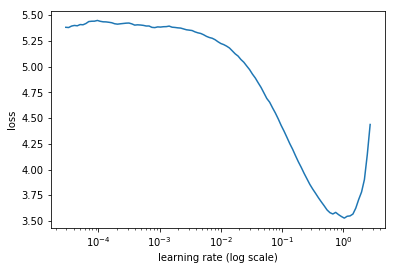

In [30]:
learn.sched.plot()

In [31]:
learn.save('224_1')

In [32]:
learn.set_data(get_data(299,64))

In [33]:
lr = 0.1
learn.fit(lr,3,cycle_len = 1)

Exception in thread Thread-26:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))


epoch      trn_loss   val_loss   accuracy                   
    0      1.217201   0.558032   0.833789  
    1      0.870549   0.504623   0.83916                     
    2      0.700521   0.484062   0.846517                    



[0.48406205, 0.846516927704215]

In [34]:
learn.save('299_1')

In [38]:
learn.load('299_1')
learn.set_data(get_data(400,64))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 91%|█████████▏| 117/128 [02:17<00:12,  1.18s/it, loss=2.4]  

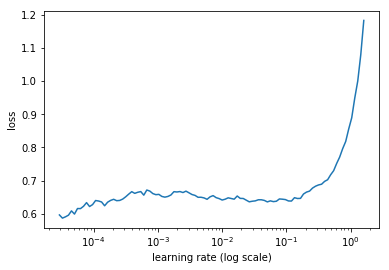

In [36]:
learn.lr_find()
learn.sched.plot()

In [39]:
lr = 1e-2
%time learn.fit(lr,3,cycle_len = 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.641388   0.504421   0.836719  
    1      0.613538   0.500632   0.843522                    
    2      0.607575   0.492795   0.846452                    

CPU times: user 11min 45s, sys: 2min 46s, total: 14min 32s
Wall time: 8min 53s


[0.49279538, 0.846451822668314]

In [40]:
learn.save('400_1')

In [43]:
learn.load('400_1')
lrs = np.array([lr/100,lr/10,lr])
learn.unfreeze()
learn.bn_freeze(True)
%time learn.fit(lrs,3,cycle_len=1,cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.621844   0.494699   0.838639  
    1      0.677739   0.558893   0.821549                    
    2      0.458814   0.462362   0.853776                    
    3      0.618027   0.633273   0.803418                    
    4      0.497714   0.561145   0.823958                    
    5      0.330594   0.495125   0.847917                    
    6      0.264775   0.477799   0.851888                    

CPU times: user 47min 3s, sys: 10min 18s, total: 57min 21s
Wall time: 39min 58s


[0.47779885, 0.851888021454215]

In [44]:
learn.save('400_2')

In [45]:
FileLink(f'{PATH}models/400_2.h5')

/home/paperspace/practice/data/dogbreed/models/400_2.h5

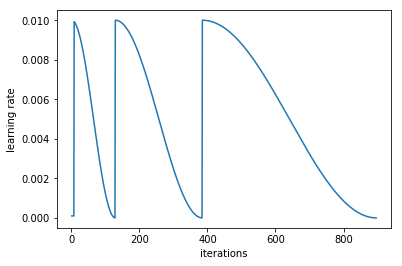

In [46]:
learn.sched.plot_lr()

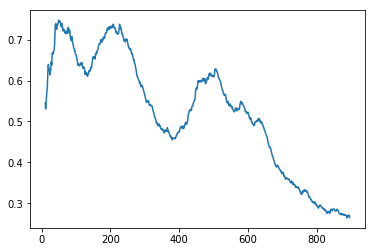

In [47]:
learn.sched.plot_loss()

In [48]:
pred_log,y = learn.TTA(is_test = True)

In [54]:
pred_log_m = np.mean(pred_log,0);pred_log_m.shape

(10357, 120)

In [56]:
pred = np.exp(pred_log_m)

In [60]:
df = pd.DataFrame(pred)
df.columns = data.classes
df.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,3.845954e-10,9.433478e-07,2.386215e-09,3.875006e-08,4.443243e-11,1.240021e-10,4.288901e-10,9.618398e-11,3.059363e-10,2.629091e-12,...,4.378375e-10,1.818251e-12,1.227245e-09,1.368479e-11,1.051872e-08,2.938853e-09,1.379895e-09,3.670873e-09,1.851629e-08,3.901394e-11
1,8.345556e-07,9.563259e-08,9.514403e-09,6.853242e-09,2.776327e-09,3.648091e-09,3.704807e-08,2.150071e-08,1.284138e-08,9.225744e-12,...,8.775714e-10,8.832873e-11,3.402884e-10,2.426030e-09,7.726172e-10,1.805138e-08,5.350204e-07,5.513285e-08,1.493474e-07,4.606854e-09
2,3.386114e-07,1.090928e-07,2.082077e-08,1.009106e-02,4.584915e-08,3.531047e-08,1.231090e-06,1.198670e-06,1.870867e-07,5.672229e-08,...,1.316033e-07,2.053653e-07,4.686972e-07,4.157947e-07,4.047831e-09,2.149075e-08,6.707144e-08,7.228723e-06,3.484217e-01,1.574727e-07
3,5.410110e-06,6.094171e-08,3.145004e-07,1.683162e-07,4.687459e-09,2.820414e-07,2.455133e-06,2.048274e-07,1.078232e-09,2.252536e-09,...,1.653097e-07,1.057247e-07,7.605083e-10,2.273969e-09,4.644636e-08,1.441110e-08,2.459375e-05,2.943904e-08,2.180029e-05,6.334464e-06
4,1.087692e-06,6.271541e-10,2.308641e-10,1.348939e-06,1.322060e-09,5.274767e-09,2.584349e-09,1.172799e-08,3.080242e-10,8.703930e-11,...,1.272852e-07,1.124969e-09,4.488493e-10,4.856572e-09,1.820182e-10,1.344027e-10,1.273428e-08,2.891422e-08,8.552583e-06,3.976338e-08


In [61]:
fnames = [f[5:-4] for f in data.test_ds.fnames]
fnames[:3]

['de084b830010b6107215fef5d4a75b94',
 '6b423ca7020e70eb05732843c5d2bad1',
 '74aa7e201e0e93e13e87b986a7d31839']

In [62]:
df.insert(0,'id',fnames)
df.tail()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
10352,9f045f337a40c266d3bf2fdc5d530693,2.262850e-07,1.422632e-07,1.435491e-08,5.652702e-03,4.235631e-07,4.714412e-07,3.402812e-07,3.531994e-06,3.269382e-07,...,2.733867e-04,2.160945e-06,3.926845e-07,5.076048e-07,5.199392e-07,4.655794e-08,5.837174e-06,3.055959e-07,9.441998e-03,1.645025e-06
10353,939a9c2e93ea2cbfc22f3099e5eea63d,2.934350e-09,1.440020e-10,7.983159e-06,6.032182e-09,4.417517e-09,1.293367e-09,2.666273e-09,5.797056e-09,1.643937e-10,...,3.094914e-09,6.842584e-09,1.240751e-09,4.577974e-09,5.128568e-08,4.644616e-09,6.595188e-09,1.050801e-08,1.731697e-09,4.864014e-10
10354,f2e0d5786be8d06a284ffd09c056f637,1.244564e-09,1.667225e-10,7.145180e-08,3.774094e-09,5.126736e-09,5.735773e-07,3.171338e-08,3.192671e-06,5.179270e-07,...,5.032997e-09,2.816993e-06,1.026298e-09,6.840869e-07,3.322719e-10,1.360589e-07,3.615873e-08,2.237405e-08,8.963307e-09,6.918992e-09
10355,1618763d5cd4c51c555ea05a3048a117,1.421156e-12,1.735979e-10,1.687571e-12,3.622213e-14,6.344132e-15,7.836102e-17,2.328385e-11,3.979789e-16,1.708783e-12,...,5.275023e-15,2.468960e-15,4.626678e-12,4.810698e-16,4.733810e-13,1.464627e-12,1.099052e-16,8.872395e-16,1.477808e-15,8.351311e-13
10356,d0abf32cdef48936e7c843311121ab0b,3.238223e-10,4.106694e-12,4.222851e-10,4.448722e-11,2.161614e-11,1.964345e-09,3.900773e-09,1.975432e-05,2.361329e-11,...,2.732763e-07,9.911152e-01,3.122251e-10,2.343284e-10,6.001286e-10,3.238664e-12,3.869681e-08,3.773439e-09,1.563217e-09,3.739150e-07


In [64]:
sub = f'{PATH}sub.csv'
df.to_csv(sub,index=False)
FileLink(sub)

/home/paperspace/practice/data/dogbreed/sub.csv